## Reserve and configure resources on KVM

Before you run this experiment, you will:

-   define the specific configuration of resources you need.
-   “instantiate” an experiment with your reserved resources.
-   wait for your resources to be configured.
-   log in to resources to carry out the experiment.

This exercise will guide you through those steps.

### Configure environment

In [140]:
import openstack, chi, chi.ssh, chi.network, chi.server, os

In this section, we configure the Chameleon Python client.

For this experiment, we’re going to use the KVM@TACC site, which we indicate below.

We also need to specify the name of the Chameleon “project” that this experiment is part of. The project name will have the format “CHI-XXXXXX”, where the last part is a 6-digit number, and you can find it on your [user dashboard](https://chameleoncloud.org/user/dashboard/).

In the cell below, replace the project ID with your own project ID, then run the cell.

In [141]:
chi.use_site("KVM@TACC")
PROJECT_NAME = "CHI-231138"
chi.set("project_name", PROJECT_NAME)

# configure openstacksdk for actions unsupported by python-chi
os_conn = chi.clients.connection()


Now using KVM@TACC:
URL: https://kvm.tacc.chameleoncloud.org
Location: Austin, Texas, USA
Support contact: help@chameleoncloud.org


### Define configuration for this experiment (3 VMs)

For this specific experiment, we will need three virtual machines connected to a common network. Each of the virtual machines will be of the `m1.large` type, with 4 VCPUs, 8 GB memory, 40 GB disk space.

In [142]:
username = os.getenv('USER')

node_conf = [
 {'name': "node-0",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu20.04', 'packages': ["virtualenv"], 'bastion': True}, 
 {'name': "node-1",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu20.04', 'packages': [], 'bastion': False}, 
 {'name': "node-2",  'flavor': 'm1.medium', 'image': 'CC-Ubuntu20.04', 'packages': [], 'bastion': False} 
]
net_conf = [
 {"name": "net0", "subnet": "192.168.1.0/24", "nodes": [{"name": "node-0",   "addr": "192.168.1.10"}, {"name": "node-1", "addr": "192.168.1.11"}, {"name": "node-2", "addr": "192.168.1.12"}]},
]
route_conf = []

### Configure resources

Now, we will prepare the VMs and network links that our experiment requires.

First, we will prepare a “public” network that we will use for SSH access to our VMs -

In [13]:
public_net = os_conn.network.create_network(name="public_net_" + username)
public_net_id = public_net.get("id")
public_subnet = os_conn.network.create_subnet(
    name="public_subnet_" + username,
    network_id=public_net.get("id"),
    ip_version='4',
    cidr="192.168.10.0/24",
    gateway_ip="192.168.10.1",
    is_dhcp_enabled = True
)

Next, we will prepare the “experiment” networks -

In [14]:
nets = []
net_ids = []
subnets = []
for n in net_conf:
    exp_net = os_conn.network.create_network(name="exp_" + n['name']  + '_' + username)
    exp_net_id = exp_net.get("id")
    os_conn.network.update_network(exp_net, is_port_security_enabled=False)
    exp_subnet = os_conn.network.create_subnet(
        name="exp_subnet_" + n['name']  + '_' + username,
        network_id=exp_net.get("id"),
        ip_version='4',
        cidr=n['subnet'],
        gateway_ip=None,
        is_dhcp_enabled = True
    )
    nets.append(exp_net)
    net_ids.append(exp_net_id)
    subnets.append(exp_subnet)

Now we create the VMs -

In [15]:
servers = []
server_ids = []
for i, n in enumerate(node_conf, start=10):
    image_uuid = os_conn.image.find_image(n['image']).id
    flavor_uuid = os_conn.compute.find_flavor(n['flavor']).id
    # find out details of exp interface(s)
    nics = [{'net-id': chi.network.get_network_id( "exp_" + net['name']  + '_' + username ), 'v4-fixed-ip': node['addr']} for net in net_conf for node in net['nodes'] if node['name']==n['name']]
    # also include a public network interface
    nics.insert(0, {"net-id": public_net_id, "v4-fixed-ip":"192.168.10." + str(i)})
    server = chi.server.create_server(
        server_name=n['name'] + "_" + username,
        image_id=image_uuid,
        flavor_id=flavor_uuid,
        nics=nics
    )
    servers.append(server)
    server_ids.append(chi.server.get_server(n['name'] + "_" + username).id)

We wait for all servers to come up before we proceed -

In [16]:
for server_id in server_ids:
    chi.server.wait_for_active(server_id)

Next, we will set up SSH access to the VMs.

First, we will make sure the “public” network is connected to the Internet. Then, we will configure it to permit SSH access on port 22 for each port connected to this network.

In [17]:
# connect them to the Internet on the "public" network (e.g. for software installation)
router = chi.network.create_router('inet_router_' + username, gw_network_name='public')
chi.network.add_subnet_to_router(router.get("id"), public_subnet.get("id"))

{'network_id': '95a4e9e7-6023-4ecd-84e6-046a452973b5',
 'tenant_id': '13a1ac1ce275484caedc3394339486a1',
 'subnet_id': '2334f627-ae29-4e93-86d9-392daac4de5f',
 'subnet_ids': ['2334f627-ae29-4e93-86d9-392daac4de5f'],
 'port_id': 'bc804260-3633-4ee8-b69a-c1fb9ecc24c7',
 'id': '26e5466d-ff14-46c8-ba3b-ab3f822b463a'}

In [18]:
print(server_ids)

['4c276415-f923-45c1-b468-05effad7dd59', '47e042a8-1212-4e8f-a35d-2e7b090d4bbe', '34a72289-0d10-4fd9-8e6d-11e275984202']


In [19]:
# prepare SSH access on the servers that serve in "bastion" role
# WARNING: this relies on undocumented behavior of associate_floating_ip 
# that it associates the IP with the first port on the server
server_ips = []
for i, n in enumerate(node_conf):
    if 'bastion' in n and n['bastion']:
        ip = chi.server.associate_floating_ip(server_ids[i])
        server_ips.append(ip)

SDKException: No port on server 4c276415-f923-45c1-b468-05effad7dd59 was found matching your NAT destination network public_net_vrj2006_nyu_edu.Please check your config

In [23]:
ip = '129.114.25.138'
server_ips.append(ip)

In [20]:
if not os_conn.get_security_group("Allow SSH"):
    os_conn.create_security_group("Allow SSH", "Enable SSH traffic on TCP port 22")
    os_conn.create_security_group_rule("Allow SSH", port_range_min=22, port_range_max=22, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

security_group_id = os_conn.get_security_group("Allow SSH").id
for port in chi.network.list_ports():
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        os_conn.network.update_port(port['id'], security_groups=[security_group_id])

In [21]:
for ip in server_ips:
    chi.server.wait_for_tcp(ip, port=22)

The following cell may raise an error if some of your nodes are still getting set up! If that happens, wait a few minutes and try again. (And then a few minutes more, and try again, if it still raises an error.)

In [24]:
primary_remote = chi.ssh.Remote(server_ips[0])
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
server_remotes = [chi.ssh.Remote(physical_ip, gateway=primary_remote) for physical_ip in physical_ips]

Finally, we need to configure our resources, including software package installation and network configuration.

In [25]:
import time
for i, n in enumerate(node_conf):
    remote = server_remotes[i]
    # enable forwarding
    remote.run(f"sudo sysctl -w net.ipv4.ip_forward=1") 
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=192.168.0.0/16 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=172.16.0.0/12 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=10.0.0.0/8 --permanent")
    remote.run(f"sudo firewall-cmd --zone=trusted --add-source=127.0.0.0/8 --permanent")
    # these are required for etcd
    remote.run(f"sudo firewall-cmd --zone=public --add-port=4001/tcp")
    remote.run(f"sudo firewall-cmd --zone=public --add-port=2379-2380/tcp")
    time.sleep(3)

/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 129.114.25.138: b'1fee9a83f9ac610c4f0eb940f6fab897'
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.10: b'1fee9a83f9ac610c4f0eb940f6fab897'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.11: b'1abb803285be085ffe3b0197fb577c1c'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success


/opt/conda/lib/python3.10/site-packages/paramiko/client.py:889: UserWarning: Unknown ssh-ed25519 host key for 192.168.1.12: b'c68f3ccf7b9baa2debaab73c39af57cf'
  warnings.warn(


net.ipv4.ip_forward = 1
success
success
success
success
success
success


In [26]:
for i, n in enumerate(node_conf):
    # install packages
    if len(n['packages']):
            remote = server_remotes[i]
            remote.run(f"sudo apt update; sudo apt -y install " + " ".join(n['packages'])) 

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [128 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal InRelease [265 kB]
Get:3 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [3357 kB]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates InRelease [128 kB]
Get:5 http://nova.clouds.archive.ubuntu.com/ubuntu focal-backports InRelease [128 kB]
Get:6 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/main amd64 Packages [3735 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/main amd64 c-n-f Metadata [14.3 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [3343 kB]
Get:9 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 c-n-f Metadata [548 B]
Get:10 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [1031 kB]
Get:11 http://security.ubuntu.com/ubuntu focal-security/universe amd64 c-n-f Metadata [21.4 kB]
Get:12 http://security.ubuntu.com/ubu

Reading package lists...
Building dependency tree...
Reading state information...
The following additional packages will be installed:
  python3-appdirs python3-distlib python3-filelock python3-virtualenv
The following NEW packages will be installed:
  python3-appdirs python3-distlib python3-filelock python3-virtualenv
  virtualenv
0 upgraded, 5 newly installed, 0 to remove and 42 not upgraded.
Need to get 199 kB of archives.
After this operation, 1056 kB of additional disk space will be used.
Get:1 http://nova.clouds.archive.ubuntu.com/ubuntu focal/main amd64 python3-appdirs all 1.4.3-2.1 [10.8 kB]
Get:2 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 python3-distlib all 0.3.0-1 [116 kB]
Get:3 http://nova.clouds.archive.ubuntu.com/ubuntu focal/universe amd64 python3-filelock all 3.0.12-2 [7948 B]
Get:4 http://nova.clouds.archive.ubuntu.com/ubuntu focal-updates/universe amd64 python3-virtualenv all 20.0.17-1ubuntu0.4 [62.7 kB]
Get:5 http://nova.clouds.archive.ubuntu.c

debconf: unable to initialize frontend: Dialog
debconf: (Dialog frontend will not work on a dumb terminal, an emacs shell buffer, or without a controlling terminal.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 


Fetched 199 kB in 1s (269 kB/s)
Selecting previously unselected package python3-appdirs.
(Reading database ... 82222 files and directories currently installed.)
Preparing to unpack .../python3-appdirs_1.4.3-2.1_all.deb ...
Unpacking python3-appdirs (1.4.3-2.1) ...
Selecting previously unselected package python3-distlib.
Preparing to unpack .../python3-distlib_0.3.0-1_all.deb ...
Unpacking python3-distlib (0.3.0-1) ...
Selecting previously unselected package python3-filelock.
Preparing to unpack .../python3-filelock_3.0.12-2_all.deb ...
Unpacking python3-filelock (3.0.12-2) ...
Selecting previously unselected package python3-virtualenv.
Preparing to unpack .../python3-virtualenv_20.0.17-1ubuntu0.4_all.deb ...
Unpacking python3-virtualenv (20.0.17-1ubuntu0.4) ...
Selecting previously unselected package virtualenv.
Preparing to unpack .../virtualenv_20.0.17-1ubuntu0.4_all.deb ...
Unpacking virtualenv (20.0.17-1ubuntu0.4) ...
Setting up python3-filelock (3.0.12-2) ...
Setting up python3-di

In [27]:
# prepare a "hosts" file that has names and addresses of every node
hosts_txt = [ "%s\t%s" % ( n['addr'], n['name'] ) for net in net_conf  for n in net['nodes'] if type(n) is dict and n['addr']]
for remote in server_remotes:
    for h in hosts_txt:
        remote.run("echo %s | sudo tee -a /etc/hosts > /dev/null" % h)

In [28]:
# we also need to enable incoming traffic on the HTTP port
if not os_conn.get_security_group("Allow HTTP 32000"):
    os_conn.create_security_group("Allow HTTP 32000", "Enable HTTP traffic on TCP port 32000")
    os_conn.create_security_group_rule("Allow HTTP 32000", port_range_min=32000, port_range_max=32000, protocol='tcp', remote_ip_prefix='0.0.0.0/0')

# add existing security group
security_group_id = os_conn.get_security_group("Allow HTTP 32000").id
for port in chi.network.list_ports(): 
    if port['port_security_enabled'] and port['network_id']==public_net.get("id"):
        pri_security_groups = port['security_groups']
        pri_security_groups.append(security_group_id)
        os_conn.network.update_port(port['id'], security_groups=pri_security_groups)

### Draw the network topology

The following cells will draw the network topology, for your reference.

In [29]:
!pip install networkx

In [30]:
nodes = [ (n['name'], {'color': 'pink'}) for n in net_conf ] + [(n['name'], {'color': 'lightblue'}) for n in node_conf ]
edges = [(net['name'], node['name'], 
          {'label': node['addr'] + '/' + net['subnet'].split("/")[1] }) if node['addr'] else (net['name'], node['name']) for net in net_conf for node in net['nodes'] ]

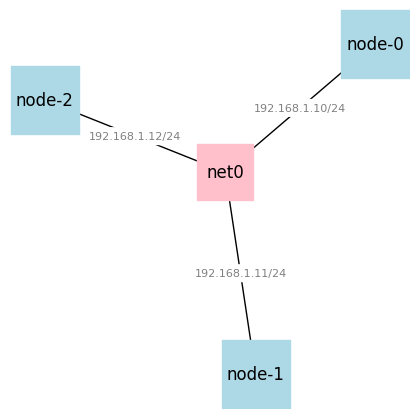

In [50]:
import networkx as nx
import matplotlib.pyplot as plt
plt.figure(figsize=(len(nodes),len(nodes)))
G = nx.Graph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
pos = nx.spring_layout(G)
nx.draw(G, pos, node_shape='s',  
        node_color=[n[1]['color'] for n in nodes], 
        node_size=[len(n[0])*400 for n in nodes],  
        with_labels=True);
nx.draw_networkx_edge_labels(G,pos,
                             edge_labels=nx.get_edge_attributes(G,'label'),
                             font_color='gray',  font_size=8, rotate=False);

### Use Kubespray to prepare a Kubernetes cluster

Now that are resources are “up”, we will use Kubespray, a software utility for preparing and configuring a Kubernetes cluster, to set them up as a cluster.

In [51]:
remote = chi.ssh.Remote(server_ips[0])

In [52]:
# install Python libraries required for Kubespray
remote.run("virtualenv -p python3 myenv")
remote.run("git clone --branch release-2.22 https://github.com/kubernetes-sigs/kubespray.git")
remote.run("source myenv/bin/activate; cd kubespray; pip3 install -r requirements.txt")

created virtual environment CPython3.8.10.final.0-64 in 608ms
  creator CPython3Posix(dest=/home/cc/myenv, clear=False, global=False)
  seeder FromAppData(download=False, pip=latest, setuptools=latest, wheel=latest, pkg_resources=latest, via=copy, app_data_dir=/home/cc/.local/share/virtualenv/seed-app-data/v1.0.1.debian.1)
  activators BashActivator,CShellActivator,FishActivator,PowerShellActivator,PythonActivator,XonshActivator


fatal: destination path 'kubespray' already exists and is not an empty directory.


UnexpectedExit: Encountered a bad command exit code!

Command: 'git clone --branch release-2.22 https://github.com/kubernetes-sigs/kubespray.git'

Exit code: 128

Stdout: already printed

Stderr: already printed



In [34]:
# copy config files to correct locations
remote.run("mv kubespray/inventory/sample kubespray/inventory/mycluster")
remote.run("git clone https://github.com/teaching-on-testbeds/k8s.git")
remote.run("cp k8s/config/k8s-cluster.yml kubespray/inventory/mycluster/group_vars/k8s_cluster/k8s-cluster.yml")
remote.run("cp k8s/config/inventory.py    kubespray/contrib/inventory_builder/inventory.py")
remote.run("cp k8s/config/addons.yml      kubespray/inventory/mycluster/group_vars/k8s_cluster/addons.yml")

Cloning into 'k8s'...


<Result cmd='cp k8s/config/addons.yml      kubespray/inventory/mycluster/group_vars/k8s_cluster/addons.yml' exited=0>

In [35]:
# build inventory for this specific topology
physical_ips = [n['addr'] for n in net_conf[0]['nodes']]
physical_ips_str = " ".join(physical_ips)
remote.run(f"source myenv/bin/activate; declare -a IPS=({physical_ips_str});"+"cd kubespray; CONFIG_FILE=inventory/mycluster/hosts.yaml python3 contrib/inventory_builder/inventory.py ${IPS[@]}")


DEBUG: Adding group all
DEBUG: Adding group kube_control_plane
DEBUG: Adding group kube_node
DEBUG: Adding group etcd
DEBUG: Adding group k8s_cluster
DEBUG: Adding group calico_rr
DEBUG: adding host node-0 to group all
DEBUG: adding host node-1 to group all
DEBUG: adding host node-2 to group all
DEBUG: adding host node-0 to group etcd
DEBUG: adding host node-1 to group etcd
DEBUG: adding host node-2 to group etcd
DEBUG: adding host node-0 to group kube_control_plane
DEBUG: adding host node-1 to group kube_control_plane
DEBUG: adding host node-0 to group kube_node
DEBUG: adding host node-1 to group kube_node
DEBUG: adding host node-2 to group kube_node


<Result cmd='source myenv/bin/activate; declare -a IPS=(192.168.1.10 192.168.1.11 192.168.1.12);cd kubespray; CONFIG_FILE=inventory/mycluster/hosts.yaml python3 contrib/inventory_builder/inventory.py ${IPS[@]}' exited=0>

In [53]:
# make sure "controller" node can SSH into the others
remote.run('ssh-keygen -t rsa -b 4096 -f ~/.ssh/id_rsa -q -N ""')
public_key = remote.run('cat ~/.ssh/id_rsa.pub').tail("stdout")[2:]

for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run(f'echo {public_key} >> ~/.ssh/authorized_keys') 

/home/cc/.ssh/id_rsa already exists.
Overwrite (y/n)? 

UnexpectedExit: Encountered a bad command exit code!

Command: 'ssh-keygen -t rsa -b 4096 -f ~/.ssh/id_rsa -q -N ""'

Exit code: 1

Stdout: already printed

Stderr: already printed



The following cell will actually build the cluster. It will take a long time, and you may see many warnings in the output - that’s OK. The instructions below explain how to tell whether it was successful or not.

The output will be very long, so it will be truncated by default. When you see

    Output of this cell has been trimmed on the initial display.
    Displaying the first 50 top outputs.
    Click on this message to get the complete output.

at the end, click in order to see the rest of the output.

When the process is finished, you will see a “PLAY RECAP” in the output (near the end):

    PLAY RECAP *********************************************************************
    localhost                  : ok=3    changed=0    unreachable=0    failed=0    skipped=0    rescued=0    ignored=0   
    node-0                     : ok=752  changed=149  unreachable=0    failed=0    skipped=1276 rescued=0    ignored=8   
    node-1                     : ok=652  changed=136  unreachable=0    failed=0    skipped=1124 rescued=0    ignored=3   
    node-2                     : ok=535  changed=112  unreachable=0    failed=0    skipped=797  rescued=0    ignored=2   

Make sure that each node shows `failed=0`. If not, you should re-run the cell to re-try the failed parts.

In [ ]:
# build the cluster
remote.run("source myenv/bin/activate; cd kubespray; ansible-playbook -i inventory/mycluster/hosts.yaml  --become --become-user=root cluster.yml")

In [55]:
# allow kubectl access for non-root user
remote.run("sudo cp -R /root/.kube /home/cc/.kube; sudo chown -R cc /home/cc/.kube; sudo chgrp -R cc /home/cc/.kube")

<Result cmd='sudo cp -R /root/.kube /home/cc/.kube; sudo chown -R cc /home/cc/.kube; sudo chgrp -R cc /home/cc/.kube' exited=0>

In [56]:
# check installation
remote.run("kubectl get nodes")

NAME     STATUS   ROLES           AGE   VERSION
node-0   Ready    control-plane   70m   v1.26.5
node-1   Ready    control-plane   70m   v1.26.5
node-2   Ready    <none>          68m   v1.26.5


<Result cmd='kubectl get nodes' exited=0>

### Set up Docker

Now that we have a Kubernetes cluster, we have a framework in place for container orchestration. But we still need to set up Docker, for building, sharing, and running those containers.

In [57]:
# add the user to the "docker" group on all hosts
for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("sudo groupadd -f docker; sudo usermod -aG docker $USER")

In [58]:
# set up a private distribution registry on the "controller" node for distributing containers
# note: need a brand-new SSH session in order to "get" new group membership
remote = chi.ssh.Remote(server_ips[0])
remote.run("docker run -d -p 5000:5000 --restart always --name registry registry:2")

docker: Error response from daemon: Conflict. The container name "/registry" is already in use by container "bd44356b0cc216b5e621dcdd77f0ed9249e7f053ccf979831fc26d8f848d54bd". You have to remove (or rename) that container to be able to reuse that name.
See 'docker run --help'.


UnexpectedExit: Encountered a bad command exit code!

Command: 'docker run -d -p 5000:5000 --restart always --name registry registry:2'

Exit code: 125

Stdout: already printed

Stderr: already printed



In [59]:
# set up docker configuration on all the hosts
for physical_ip in physical_ips:
    remote_worker = chi.ssh.Remote(physical_ip, gateway=remote)
    remote_worker.run("sudo wget https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json -O /etc/docker/daemon.json")
    remote_worker.run("sudo service docker restart")


--2025-01-06 19:20:12--  https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Saving to: ‘/etc/docker/daemon.json’

     0K                                                       100% 2.32M=0s

2025-01-06 19:20:12 (2.32 MB/s) - ‘/etc/docker/daemon.json’ saved [65/65]

--2025-01-06 19:20:28--  https://raw.githubusercontent.com/teaching-on-testbeds/k8s/main/config/daemon.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 65 [text/plain]
Sa

In [60]:
# check configuration
remote.run("docker run hello-world")


Hello from Docker!
This message shows that your installation appears to be working correctly.

To generate this message, Docker took the following steps:
 1. The Docker client contacted the Docker daemon.
 2. The Docker daemon pulled the "hello-world" image from the Docker Hub.
    (amd64)
 3. The Docker daemon created a new container from that image which runs the
    executable that produces the output you are currently reading.
 4. The Docker daemon streamed that output to the Docker client, which sent it
    to your terminal.

To try something more ambitious, you can run an Ubuntu container with:
 $ docker run -it ubuntu bash

Share images, automate workflows, and more with a free Docker ID:
 https://hub.docker.com/

For more examples and ideas, visit:
 https://docs.docker.com/get-started/



<Result cmd='docker run hello-world' exited=0>

### Get SSH login details

At this point, we should be able to log in to our “controller” node over SSH! Run the following cell, and observe the output - you will see an SSH command this node.

In [61]:
print("ssh cc@" + server_ips[0])

ssh cc@129.114.25.138


In [144]:
remote = chi.ssh.Remote(server_ips[0])

In [145]:
remote.run("kubectl get pods")

No resources found in default namespace.


<Result cmd='kubectl get pods' exited=0>

Now, you can open an SSH session as follows:

-   In Jupyter, from the menu bar, use File \> New \> Terminal to open a new terminal.
-   Copy the SSH command from the output above, and paste it into the terminal.

Alternatively, you can use your local terminal to log on to each node, if you prefer. (On your local terminal, you may need to also specify your key path as part of the SSH command, using the `-i` argument followed by the path to your private key.)

## Flyte Deployment v2

In [63]:
#installing helm
remote.run("curl https://raw.githubusercontent.com/helm/helm/main/scripts/get-helm-3 | bash")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 11903  100 11900    0     0      0      0 --:--:-- --:--:-- --:--:--     0

Helm v3.16.4 is already latest


3    0     0  92271      0 --:--:-- --:--:-- --:--:-- 92271


<Result cmd='curl https://raw.githubusercontent.com/helm/helm/main/scripts/get-helm-3 | bash' exited=0>

In [173]:
remote.run("kubectl get namespaces")

NAME                      STATUS   AGE
default                   Active   3h16m
flyte                     Active   51s
flytesnacks-development   Active   119m
flytesnacks-production    Active   119m
flytesnacks-staging       Active   119m
kube-node-lease           Active   3h16m
kube-public               Active   3h16m
kube-system               Active   3h16m


<Result cmd='kubectl get namespaces' exited=0>

In [172]:
#remote.run("kubectl create namespace flyte")
#Check if storageclass exists 
remote.run("kubectl get storageclass -n flyte")

No resources found


<Result cmd='kubectl get storageclass -n flyte' exited=0>

In [171]:
# remote.run("kubectl delete storageclass hostpath -n flyte")

storageclass.storage.k8s.io "hostpath" deleted


<Result cmd='kubectl delete storageclass hostpath -n flyte' exited=0>

In [148]:
# Creating storage class 

remote.run("helm repo add rimusz https://charts.rimusz.net")
remote.run("helm repo update")
remote.run("helm upgrade --install hostpath-provisioner --namespace flyte rimusz/hostpath-provisioner")

"rimusz" already exists with the same configuration, skipping
Hang tight while we grab the latest from your chart repositories...
...Successfully got an update from the "flyteorg" chart repository
...Successfully got an update from the "rimusz" chart repository
Update Complete. ⎈Happy Helming!⎈
Release "hostpath-provisioner" does not exist. Installing it now.
NAME: hostpath-provisioner
LAST DEPLOYED: Mon Jan  6 20:55:56 2025
NAMESPACE: flyte
STATUS: deployed
REVISION: 1
TEST SUITE: None
NOTES:
The Hostpath Provisioner service has now been installed.

A storage class named 'hostpath' has now been created
and is available to provision dynamic volumes.

You can use this storageclass by creating a `PersistentVolumeClaim` with the
correct storageClassName attribute. For example:

    ---
    kind: PersistentVolumeClaim
    apiVersion: v1
    metadata:
      name: test-dynamic-volume-claim
    spec:
      storageClassName: "hostpath"
      accessModes:
        - ReadWriteOnce
      resources

<Result cmd='helm upgrade --install hostpath-provisioner --namespace flyte rimusz/hostpath-provisioner' exited=0>

In [150]:
#Check if storageclass is created now 
remote.run("kubectl get storageclass -n flyte")


NAME                 PROVISIONER   RECLAIMPOLICY   VOLUMEBINDINGMODE   ALLOWVOLUMEEXPANSION   AGE
hostpath (default)   hostpath      Delete          Immediate           false                  6m58s
NAME                                   READY   STATUS    RESTARTS   AGE
hostpath-provisioner-5bb665c64-zc9mn   1/1     Running   0          6m58s


<Result cmd='kubectl get pods -n flyte' exited=0>

In [151]:
# Downloading the needed dependencies for flyte into the master node
remote.run("curl -sl https://raw.githubusercontent.com/ShaktidharK1997/flyte-artifact/refs/heads/main/onprem-flyte-dependencies.yaml > onprem-flyte-dependencies.yaml")

#running the dependencies yaml in master node 
remote.run("kubectl apply -f onprem-flyte-dependencies.yaml")

namespace/flyte configured
persistentvolumeclaim/postgresql-pvc created
persistentvolumeclaim/minio-pvc created
service/postgres created
deployment.apps/postgres created
deployment.apps/minio created
service/minio created


<Result cmd='kubectl apply -f onprem-flyte-dependencies.yaml' exited=0>

In [154]:
#checking pod status ( Object store MinIO and PgSQL database containers must be created)
remote.run("kubectl get pods -n flyte")

NAME                                   READY   STATUS    RESTARTS   AGE
hostpath-provisioner-5bb665c64-zc9mn   1/1     Running   0          9m43s
minio-6dfd8b7d76-rwlsq                 1/1     Running   0          24s
postgres-5cd768484f-z2kcx              1/1     Running   0          24s


<Result cmd='kubectl get pods -n flyte' exited=0>

In [169]:
# remote.run("kubectl delete -f onprem-flyte-dependencies.yaml")

namespace "flyte" deleted
persistentvolumeclaim "postgresql-pvc" deleted
persistentvolumeclaim "minio-pvc" deleted
service "postgres" deleted
deployment.apps "postgres" deleted
deployment.apps "minio" deleted
service "minio" deleted


<Result cmd='kubectl delete -f onprem-flyte-dependencies.yaml' exited=0>

In [155]:
#add flyte through helm repo
remote.run("helm repo add flyteorg https://flyteorg.github.io/flyte")


"flyteorg" already exists with the same configuration, skipping


<Result cmd='helm repo add flyteorg https://flyteorg.github.io/flyte' exited=0>

In [156]:
#remote.run("mkdir -p ~/flyte-config")

#Creating local secret yaml for db password
remote.run("""cat <<EOF > ~/flyte-config/local-secret.yaml      
apiVersion: v1
kind: Secret
metadata:
  name: flyte-binary-inline-config-secret
  namespace: flyte
type: Opaque
stringData:
  202-database-secrets.yaml: |
    database:
      postgres:
        password: "postgres" 
EOF
""")

#Applying local secret

remote.run("kubectl create -f ~/flyte-config/local-secret.yaml")


secret/flyte-binary-inline-config-secret created


<Result cmd='kubectl create -f ~/flyte-config/local-secret.yaml' exited=0>

In [168]:
# remote.run("kubectl delete -f ~/flyte-config/local-secret.yaml")

secret "flyte-binary-inline-config-secret" deleted


<Result cmd='kubectl delete -f ~/flyte-config/local-secret.yaml' exited=0>

In [157]:
#Installing flyte binary in K8s
remote.run("curl -sL https://raw.githubusercontent.com/davidmirror-ops/flyte-the-hard-way/main/docs/on-premises/single-node/manifests/onprem-flyte-binary-values.yaml > onprem-flyte-binary-values.yaml")

remote.run("helm install flyte-binary flyteorg/flyte-binary  --values onprem-flyte-binary-values.yaml -n flyte")


NAME: flyte-binary
LAST DEPLOYED: Mon Jan  6 21:06:31 2025
NAMESPACE: flyte
STATUS: deployed
REVISION: 1
TEST SUITE: None


<Result cmd='helm install flyte-binary flyteorg/flyte-binary  --values onprem-flyte-binary-values.yaml -n flyte' exited=0>

In [167]:
remote.run("kubectl get pods -n flyte")

NAME                                   READY   STATUS        RESTARTS   AGE
flyte-binary-658fc8b875-b66cd          1/1     Terminating   0          18m
hostpath-provisioner-5bb665c64-zc9mn   1/1     Running       0          28m
minio-6dfd8b7d76-rwlsq                 1/1     Running       0          19m
postgres-5cd768484f-z2kcx              1/1     Running       0          19m


<Result cmd='kubectl get pods -n flyte' exited=0>

In [166]:
# remote.run("helm uninstall flyte-binary -n flyte")

release "flyte-binary" uninstalled


<Result cmd='helm uninstall flyte-binary -n flyte' exited=0>

## Configuring to connect to installed Flyte

In [160]:
# Installing and configuring flytectl
remote.run("curl -sL https://ctl.flyte.org/install | sudo bash -s -- -b /usr/local/bin")
remote.run("flytectl config init")


flyteorg/flyte info checking GitHub for latest tag
flyteorg/flyte info found version: flytectl/v0.9.4 for flytectl/v0.9.4/Linux/x86_64
flyteorg/flyte info installed /usr/local/bin/flytectl
{"json":{"src":"viper.go:395"},"level":"debug","msg":"Config section [admin] updated. Firing updated event.","ts":"2025-01-06T21:07:12Z"}
{"json":{"src":"viper.go:393"},"level":"debug","msg":"Config section [otel] updated. No update handler registered.","ts":"2025-01-06T21:07:12Z"}
{"json":{"src":"viper.go:393"},"level":"debug","msg":"Config section [storage] updated. No update handler registered.","ts":"2025-01-06T21:07:12Z"}


This action will overwrite an existing config file at [/home/cc/.flyte/config.yaml]. Do you want to continue? [y/n]: Init flytectl config file at [/home/cc/.flyte/config.yaml]

<Result cmd='flytectl config init' exited=0>

In [161]:
#Need to change content of config file
config_content = """admin:
  endpoint: localhost:8089
  authType: Pkce
  insecure: true
logger:
  show-source: true
  level: 6"""

remote.run(f"""cat << 'EOF' > $HOME/.flyte/config.yaml
{config_content}
EOF""")

<Result cmd="cat << 'EOF' > $HOME/.flyte/config.yaml\nadmin:\n  endpoint: localhost:8089\n  authType: Pkce\n  insecure: true\nlogger:\n  show-source: true\n  level: 6\nEOF" exited=0>

In [162]:
#Creating DNS Service for minio yaml 
remote.run("cat /etc/hosts")

127.0.0.1 localhost localhost.localdomain

# The following lines are desirable for IPv6 capable hosts
::1 ip6-localhost ip6-loopback localhost6 localhost6.localdomain
fe00::0 ip6-localnet
ff00::0 ip6-mcastprefix
ff02::1 ip6-allnodes
ff02::2 ip6-allrouters
ff02::3 ip6-allhosts
192.168.1.10 node-0
192.168.1.11 node-1
192.168.1.12 node-2
# Ansible inventory hosts BEGIN
192.168.1.10 node-0.cluster.local node-0 
192.168.1.11 node-1.cluster.local node-1 
192.168.1.12 node-2.cluster.local node-2 
# Ansible inventory hosts END
127.0.0.1 minio.flyte.svc.cluster.local


<Result cmd='cat /etc/hosts' exited=0>

In [163]:
# Start three port forwarding sessions for Http/grpc/minio
remote.run("""
# Start port forwards in the background using &
kubectl -n flyte port-forward service/minio 9000:9000 &
kubectl -n flyte port-forward service/flyte-binary-grpc 8089:8089 &
kubectl -n flyte port-forward service/flyte-binary-http 8088:8088 &

# Store the process IDs so we can terminate them later if needed
echo $! > /tmp/flyte-portforward.pid

# Print the running port forwards
echo "Port forwards running:"
ps aux | grep "port-forward" | grep -v grep
""")

Port forwards running:
cc        462941  0.0  0.7 759336 29408 ?        Rl   21:09   0:00 kubectl -n flyte port-forward service/minio 9000:9000
cc        462942  0.0  0.9 760424 39760 ?        Sl   21:09   0:00 kubectl -n flyte port-forward service/flyte-binary-grpc 8089:8089
cc        462943  0.0  0.7 759336 31048 ?        Rl   21:09   0:00 kubectl -n flyte port-forward service/flyte-binary-http 8088:8088
Forwarding from 127.0.0.1:8089 -> 8089
Forwarding from [::1]:8089 -> 8089
Forwarding from 127.0.0.1:8088 -> 8088
Forwarding from [::1]:8088 -> 8088
Forwarding from 127.0.0.1:9000 -> 9000
Forwarding from [::1]:9000 -> 9000
Handling connection for 8089
Handling connection for 9000


E0106 21:11:13.140454  462942 portforward.go:392] error copying from local connection to remote stream: read tcp6 [::1]:8089->[::1]:59366: read: connection reset by peer


Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088
Handling connection for 8088


KeyboardInterrupt: 

In [164]:
remote.run("""
# Kill all port-forward processes
pkill -f "port-forward"
""")

<Result cmd='\n# Kill all port-forward processes\npkill -f "port-forward"\n' exited=0>

In [165]:
remote.run("kubectl get pods -n flyte")

NAME                                   READY   STATUS    RESTARTS   AGE
flyte-binary-658fc8b875-b66cd          1/1     Running   0          17m
hostpath-provisioner-5bb665c64-zc9mn   1/1     Running   0          28m
minio-6dfd8b7d76-rwlsq                 1/1     Running   0          18m
postgres-5cd768484f-z2kcx              1/1     Running   0          18m


<Result cmd='kubectl get pods -n flyte' exited=0>

In [126]:
remote.run("kubectl get endpoints minio -n flyte")

NAME    ENDPOINTS   AGE
minio   <none>      49m


<Result cmd='kubectl get endpoints minio -n flyte' exited=0>

In [124]:
remote.run("kubectl -n flyte port-forward service/minio 9000:9000 &")

error: timed out waiting for the condition


<Result cmd='kubectl -n flyte port-forward service/minio 9000:9000 &' exited=0>

In [111]:
remote.run("source myenv/bin/activate; pip install flytekit")

ERROR: gcsfs 2024.10.0 has requirement fsspec==2024.10.0, but you'll have fsspec 2024.12.0 which is incompatible.
ERROR: botocore 1.35.88 has requirement urllib3<1.27,>=1.25.4; python_version < "3.10", but you'll have urllib3 2.2.3 which is incompatible.
ERROR: s3fs 2024.10.0 has requirement fsspec==2024.10.0.*, but you'll have fsspec 2024.12.0 which is incompatible.


<Result cmd='source myenv/bin/activate; pip install flytekit' exited=0>

In [114]:
# Create and execute dummy workflow script to test 

remote.run("""cat <<EOF >hello_world.py
from flytekit import task, workflow

@task
def say_hello() -> str:
    return "hello world"

@workflow
def my_wf() -> str:
    res = say_hello()
    return res

if __name__ == "__main__":
    print(f"Running my_wf() {my_wf()}")
EOF""")
remote.run("source myenv/bin/activate; pyflyte run --remote hello_world.py my_wf")

Running Execution on Remote.
╭───────────────────── Traceback (most recent call last) ──────────────────────╮
│ /home/cc/myenv/lib/python3.8/site-packages/grpc/_interceptor.py:315 in       │
│ continuation                                                                 │
│                                                                              │
│   312 │   │   │   │   new_compression,                                       │
│   313 │   │   │   ) = _unwrap_client_call_details(new_details, client_call_d │
│   314 │   │   │   try:                                                       │
│ ❱ 315 │   │   │   │   response, call = self._thunk(new_method).with_call(    │
│   316 │   │   │   │   │   request,                                           │
│   317 │   │   │   │   │   timeout=new_timeout,                               │
│   318 │   │   │   │   │   metadata=new_metadata,                             │
│                                                                              │

UnexpectedExit: Encountered a bad command exit code!

Command: 'source myenv/bin/activate; pyflyte run --remote hello_world.py my_wf'

Exit code: 1

Stdout: already printed

Stderr: already printed



## Flyte Deployment v1



In [ ]:
remote.run("mkdir -p ~/flyte-config")

In [ ]:
remote.run("""cat > ~/flyte-config/postgres.yaml << 'EOF'
apiVersion: v1
kind: PersistentVolumeClaim
metadata:
  name: postgres-pvc
spec:
  accessModes:
    - ReadWriteOnce
  resources:
    requests:
      storage: 10Gi
---
apiVersion: apps/v1
kind: Deployment
metadata:
  name: postgres
spec:
  selector:
    matchLabels:
      app: postgres
  template:
    metadata:
      labels:
        app: postgres
    spec:
      containers:
      - name: postgres
        image: postgres:13
        env:
        - name: POSTGRES_DB
          value: flyteadmin
        - name: POSTGRES_USER
          value: postgres
        - name: POSTGRES_PASSWORD
          value: postgrespassword
        ports:
        - containerPort: 5432
        volumeMounts:
        - name: postgres-storage
          mountPath: /var/lib/postgresql/data
      volumes:
      - name: postgres-storage
        persistentVolumeClaim:
          claimName: postgres-pvc
---
apiVersion: v1
kind: Service
metadata:
  name: postgres
spec:
  ports:
  - port: 5432
  selector:
    app: postgres
EOF""")

In [ ]:
remote.run("""cat > ~/flyte-config/minio.yaml << 'EOF'
apiVersion: apps/v1
kind: Deployment
metadata:
  name: minio
spec:
  selector:
    matchLabels:
      app: minio
  template:
    metadata:
      labels:
        app: minio
    spec:
      containers:
      - name: minio
        image: minio/minio
        args:
        - server
        - /data
        - --console-address
        - ":9001"
        env:
        - name: MINIO_ROOT_USER
          value: minio
        - name: MINIO_ROOT_PASSWORD
          value: miniostorage
        ports:
        - containerPort: 9000
        - containerPort: 9001
---
apiVersion: v1
kind: Service
metadata:
  name: minio
spec:
  ports:
  - port: 9000
    name: minio
  - port: 9001
    name: console
  selector:
    app: minio
EOF""")

In [ ]:
# Create Flyte values configuration
remote.run("""cat > ~/flyte-config/flyte-values.yaml << 'EOF'
configuration:
  database:
    host: postgres
    port: 5432
    dbname: flyteadmin
    username: postgres
    password: postgrespassword
  storage:
    type: minio
    container: my-bucket
    connection:
      access-key: minio
      auth-type: accesskey
      secret-key: miniostorage
      secure: false
      endpoint: "http://minio.flyte:9000"
  auth:
    enabled: false
EOF""")

In [ ]:
remote.run("curl https://raw.githubusercontent.com/helm/helm/main/scripts/get-helm-3 | bash")

In [ ]:
remote.run("helm repo add flyteorg https://flyteorg.github.io/flyte")

In [ ]:
remote.run("helm repo update")

In [ ]:
remote.run("kubectl create namespace flyte")

In [ ]:
remote.run("kubectl apply -n flyte -f ~/flyte-config/postgres.yaml")

In [ ]:
remote.run("kubectl apply -n flyte -f ~/flyte-config/minio.yaml")

In [ ]:
remote.run("kubectl wait --for=condition=ready pod -l app=postgres -n flyte --timeout=300s")

In [ ]:
remote.run("kubectl wait --for=condition=ready pod -l app=minio -n flyte --timeout=300s")

In [ ]:
remote.run("helm install -n flyte flyte-backend flyteorg/flyte-binary --values ~/flyte-config/flyte-values.yaml")

In [ ]:
remote.run("kubectl wait --for=condition=ready pod -l app.kubernetes.io/name=flyte-binary -n flyte --timeout=300s")

In [ ]:
remote.run("kubectl -n flyte port-forward service/flyte-binary 8088:8088 8089:8089 &")

In [ ]:
remote.run("""mkdir -p ~/.flyte
cat > ~/.flyte/config.yaml <<EOF
admin:
  endpoint: dns:///localhost:8088
  insecure: true
EOF""")

In [ ]:
remote.run("pip install flytekit")

In [ ]:
print("""
Flyte is now installed! To access the UI:
1. SSH into the controller node using: ssh cc@{server_ip}
2. The Flyte UI will be available at: http://localhost:8088/console
3. For running workflows, use the flytectl configuration at ~/.flyte/config.yaml
""".format(server_ip=server_ips[0]))